# Visualize attributes correlation and predict international appearances of a player as a classification problem. 

### Import Libraries

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy import stats
import seaborn as sn
import statsmodels.api as sm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

### Import OS

In [2]:
#Import os
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/football-manager-data/dataset.csv


### Read Dataset

In [3]:
#Read dataset
df = pd.read_csv('../input/football-manager-data/dataset.csv', sep = ',')

### Test Data are readed properly

In [4]:
#Test Data are readed properly
df.tail(10)

,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,AttackingMidRight,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight
159531,981350,Abbe Ibrahim,50,25-07-1986,29,2,0,0,0,177,...,1,1,1,1,1,1,1,1,1,1
159532,981880,Carlos García Domínguez,1653,13-05-1981,35,0,0,0,0,176,...,1,1,1,1,1,1,1,1,1,1
159533,981882,André Hainault,364,17-06-1986,30,44,2,17,0,187,...,1,20,15,17,8,1,1,1,12,13
159534,981907,Alexis Rivera,383,29-10-1982,33,17,0,0,0,176,...,1,15,20,18,1,1,1,1,14,1
159535,981918,Matthew Delicâte,801,07-02-1982,34,0,0,0,0,191,...,1,1,1,1,1,1,1,1,1,1
159536,981931,Scott Palguta,390,23-08-1982,33,0,0,0,0,188,...,1,17,20,10,1,1,1,1,13,1
159537,981959,Jamie Dodds,364,12-11-1981,34,0,0,0,0,183,...,15,1,1,1,1,12,1,1,1,1
159538,981962,Desmond Tachie,364,01-05-1984,32,0,0,0,0,178,...,1,1,1,1,1,1,10,1,1,1
159539,981967,Joey Gjertsen,390,13-06-1982,34,0,0,0,0,176,...,16,1,1,1,4,10,13,20,1,1
159540,981968,Josh Wicks,390,01-11-1983,32,0,0,0,0,192,...,1,1,1,1,1,1,1,1,1,1


### Create custom function to read missing values per column

In [5]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

### Get column types, count nans, get stats 

In [6]:
#Get column types
df.info()

#Get statistics (avg,median,percentiles) for all columns of dataset
stats = df.describe()

print(stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159541 entries, 0 to 159540
Data columns (total 89 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   UID                  159541 non-null  int64 
 1   Name                 159541 non-null  object
 2   NationID             159541 non-null  int64 
 3   Born                 159541 non-null  object
 4   Age                  159541 non-null  int64 
 5   IntCaps              159541 non-null  int64 
 6   IntGoals             159541 non-null  int64 
 7   U21Caps              159541 non-null  int64 
 8   U21Goals             159541 non-null  int64 
 9   Height               159541 non-null  int64 
 10  Weight               159541 non-null  int64 
 11  AerialAbility        159541 non-null  int64 
 12  CommandOfArea        159541 non-null  int64 
 13  Communication        159541 non-null  int64 
 14  Eccentricity         159541 non-null  int64 
 15  Handling             159541 non-nu

In [7]:
#Count missing values
missing_values_table(df)

Your selected dataframe has 89 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
PositionsDesc,32,0.0


### Create a barchat based on Age bins (6-year bins)

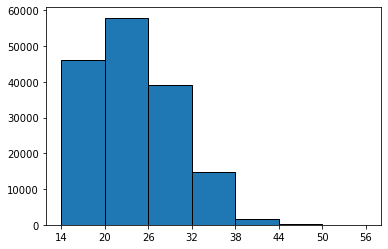

In [8]:
bins= [14,20,26,32,38,44,50,56]
plt.hist(df['Age'].values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

#### Most players are between 20 and 26 years old

### Create correlation matrix for numeric variables****


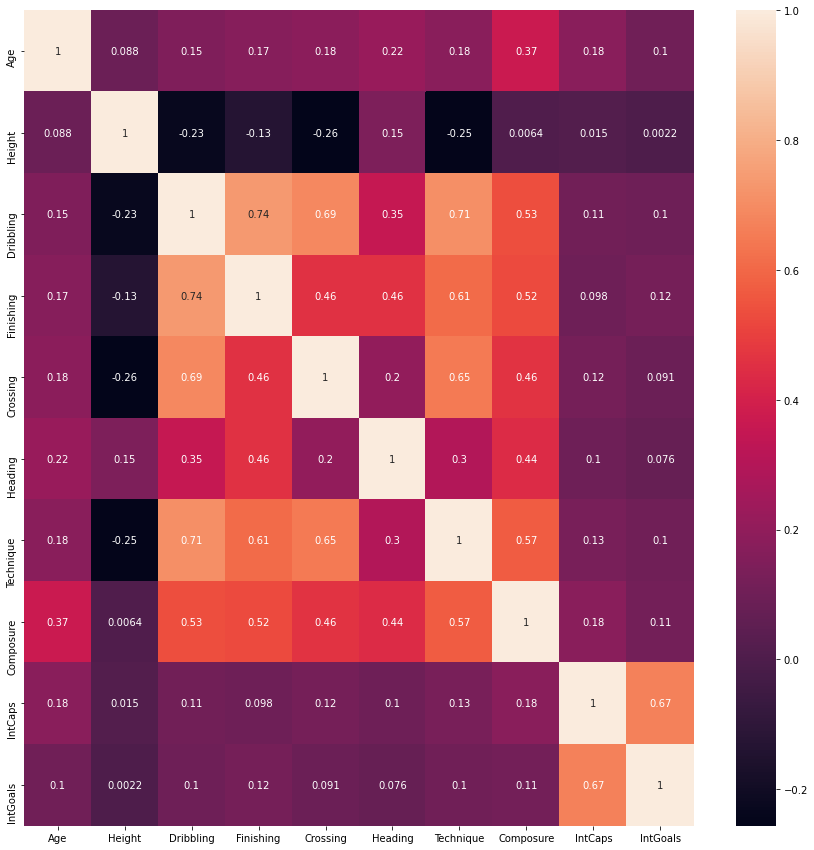

In [9]:
#Slice dataframe for specific columns in order to inspect correlations (seperate dfs for Attack, Mental)

#Attack
corr_df_attack = df.loc[:, ['Age', 'Height','Dribbling', 'Finishing','Crossing','Heading','Technique','Composure','IntCaps','IntGoals']]

#Mental
corr_df_mental = df.loc[:, ['Age', 'Height','Aggression', 'Anticipation','Bravery','Concentration','Ambition','Loyalty','Professional','Sportsmanship','Temperament','Controversy','Adaptability','Dirtiness','IntCaps','IntGoals']]

#Inspect corr matrix attack
corrMatrix_attack = corr_df_attack.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
ax = sn.heatmap(corrMatrix_attack, annot=True)
plt.show()

#### Many correlations here are obvious i.e IntCaps, IntGoals etc. Some noteworthy correlations here are Age~Composure and in general combinations that are not predictable. All correlations for attackers main attributes are predictable.

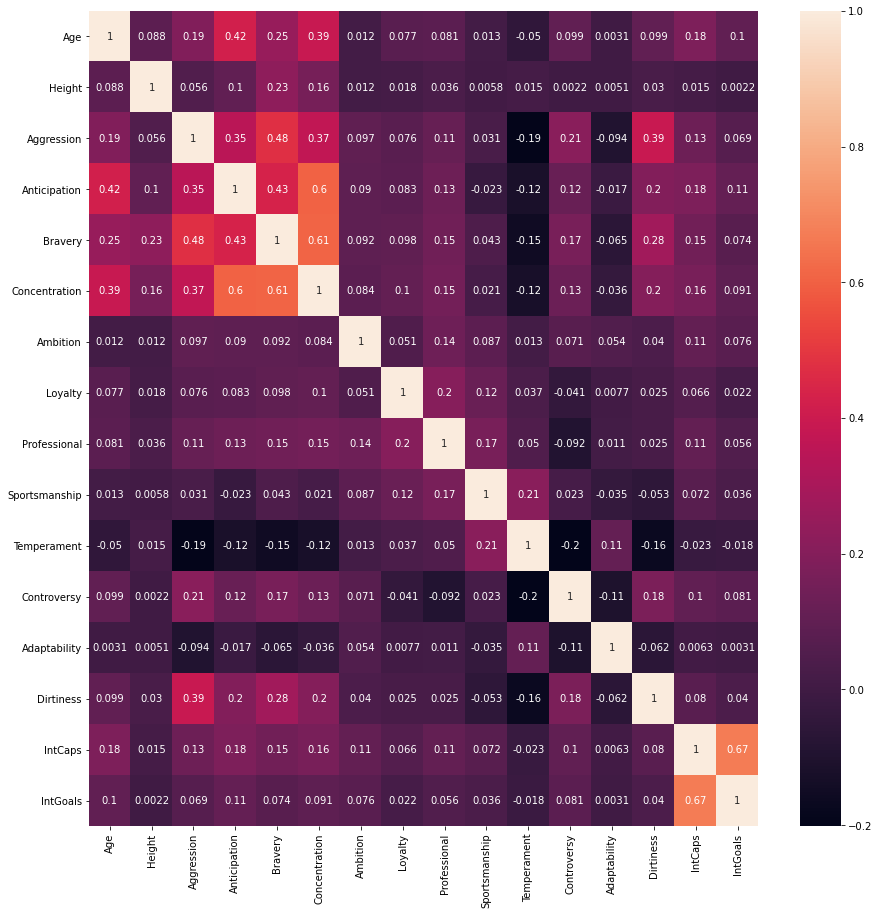

In [10]:
#Inspect corr matrix mental
corrMatrix_mental = corr_df_mental.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
ax = sn.heatmap(corrMatrix_mental, annot=True)
plt.show()

#### Mental correlations are more interesting in an insights point of view. We observe that Age is medium correlated with Anticipation & Concentration but maybe its obvious due to a player's experience. These are attrbute that increase with time. 

### Inspect players with >0 IntCaps (Correlation matrices)

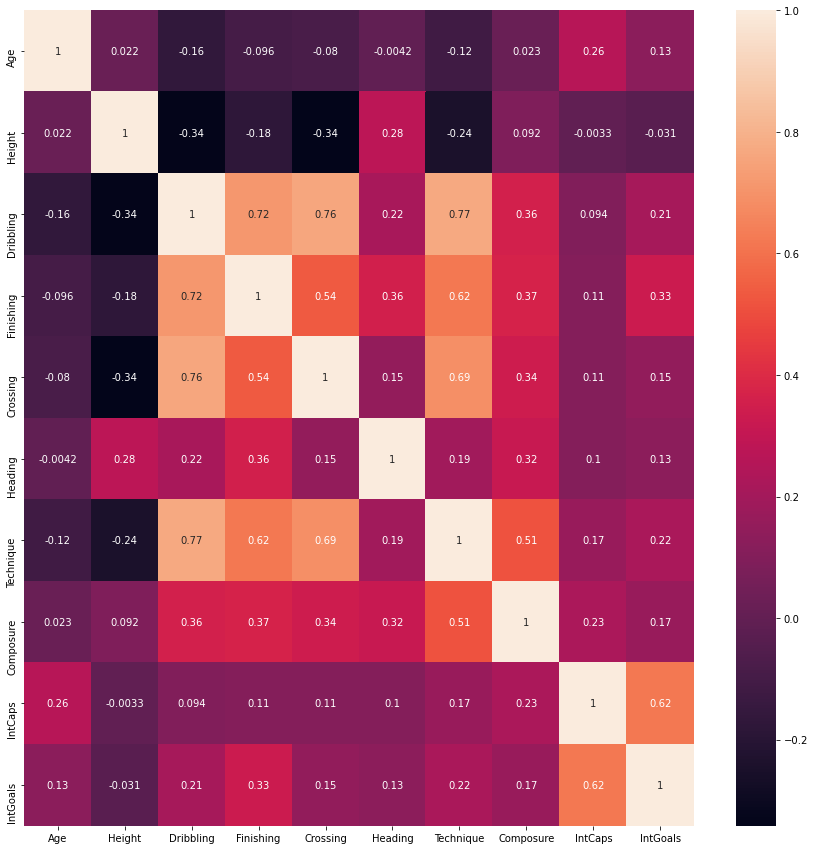

In [11]:
#Inspect players with >0 IntCaps

international = df.loc[df['IntCaps'] > 0]

#From 159.541 players, 9636 have made >0 international appearances

#Inspect the corralations but only for international players 

#Attack
corr_df_attack_int = international.loc[:, ['Age', 'Height','Dribbling', 'Finishing','Crossing','Heading','Technique','Composure','IntCaps','IntGoals']]
corr_df_mental_int = international.loc[:, ['Age', 'Height','Aggression', 'Anticipation','Bravery','Concentration','Ambition','Loyalty','Professional','Sportsmanship','Temperament','Controversy','Adaptability','Dirtiness','IntCaps','IntGoals']]

#Inspect corr matrix attack
corrMatrix_attack_int = corr_df_attack_int.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
ax = sn.heatmap(corrMatrix_attack_int, annot=True)
plt.show()


#### For players with at least 1 internation cap we get the same correlation matrix for previous compared attributes and we notice that for a (random) selected pool of attributes composure is the most highly correlated attribute with IntCaps. 

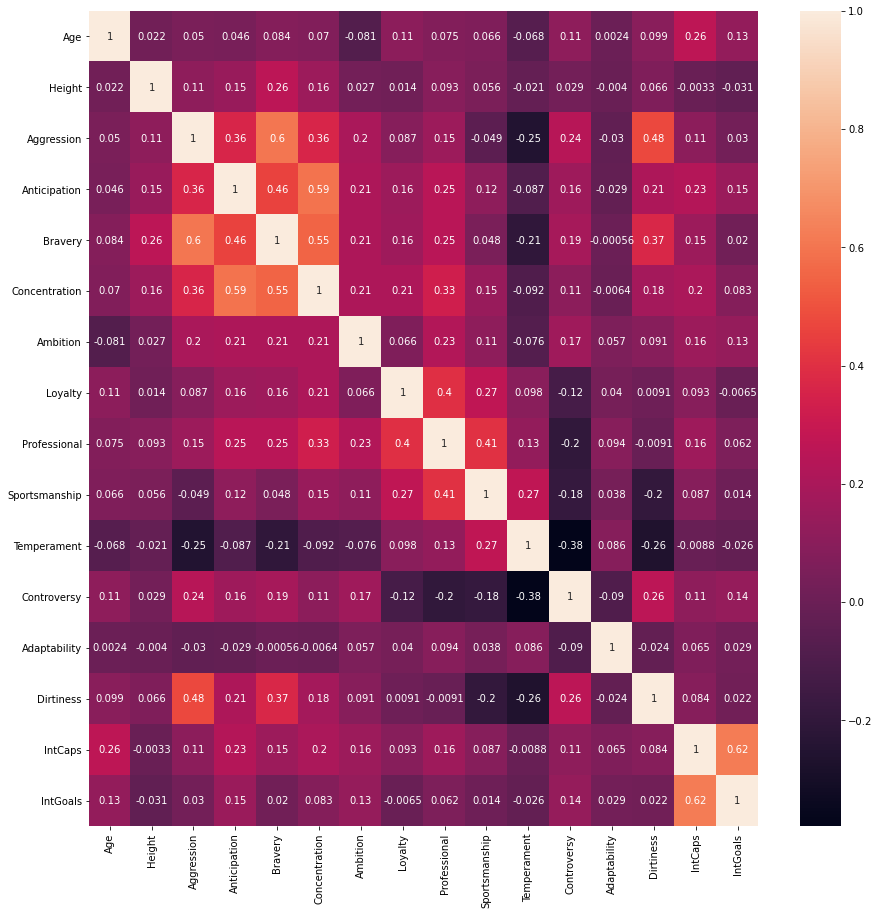

In [12]:
#Inspect corr matrix mental
corrMatrix_mental_int = corr_df_mental_int.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
ax = sn.heatmap(corrMatrix_mental_int, annot=True)
plt.show()

#### For players with at least 1 internation cap we get the same mental attributes correlation matrix for previous compared attributes and we notice that for a (random) selected pool of attributes Anticipation is the most highly correlated attribute with IntCaps. Also, for international players bravery is more correlated with Concentration. 

### Pair Scatterplots for IntCaps and Controversy-Adaptability-Dirtiness

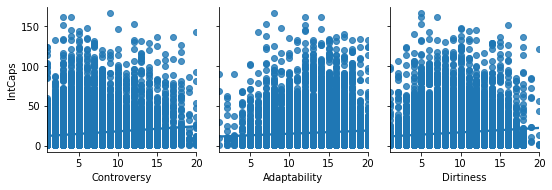

In [13]:
#Pair Scatterplots for IntCaps and Controversy-Adaptability-Dirtiness
g = sns.pairplot(data= df.query('IntCaps > 0'),
                  y_vars=['IntCaps'],
                  x_vars=['Controversy','Adaptability','Dirtiness'],
                kind="reg")

#### We get the plots to inspect the behaviour of the data points between Controversy, Adaptability, Dirtiness with International appearances.

### Create categorical variable for IntCaps

In [14]:
#Create categorical variable for IntCaps

#Inspect IntCaps distribution only for those who hade made a single or more appearances
international['IntCaps'].describe()

def caps_categorical(row):
   if  (row['IntCaps'] <= 7):
       return 0
   else:
       return 1
   
international['IntCaps_categorical'] = international.apply (lambda row: caps_categorical(row), axis=1)
international['IntCaps_categorical'].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0    4873
1    4763
Name: IntCaps_categorical, dtype: int64

#### We create a new binary categorical variable which classifies the number of International Appearances based on the median value. We do this in order to implement classification algorithms trying to predict a player's number of international caps based on some of his attributes

# Predic IntCaps_categorical based on attributes (Classfication problem)


In [15]:
# Perform Feature Selection from a pool of variables
X = international.iloc[:, 22:73]
y = international['IntCaps_categorical']

cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Heading', 'Anticipation', 'Bravery', 'Composure', 'Decisions', 'Flair', 'Leadership', 'OffTheBall', 'Teamwork', 'Jumping', 'LeftFoot', 'NaturalFitness', 'RightFoot', 'Stamina', 'ImportantMatches', 'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Sportsmanship', 'Controversy']


#### From the total pool of attributes (GK attributes are excluded) a backward elimination is performed in order to find the most important predictor variables

## Create Logistic Regression Model 

In [16]:
# Create Logistic Regression Model 

# Slice Dataset
X = international[['ImportantMatches', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Sportsmanship', 'Temperament', 'Controversy']]
y = international[['IntCaps_categorical']]
y['IntCaps_categorical'].value_counts()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#Inspect y_test counts
y_test['IntCaps_categorical'].value_counts()

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
#ylabel = True
#xlabel = Predicted

print(cm)

#Extract metrics
precision_recall_fscore_support(y_test, y_pred, average='macro')
#precision, recall, fscore, support


[[743 469]
 [493 704]]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(0.6006515945339723, 0.6005866564100019, 0.6005594853975346, None)

### There's an accuracy of almost 60%. Errors are normally distributed and they do not occur for a specific category. Players with more than 7 international appearances are 1197. The prediction is better than a naive model but of course the model's accuracy is still too low.

## Create Artificial Neural Network Model 

In [17]:
# Create Artificial Neural Network Model 
X = international[['ImportantMatches', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Sportsmanship', 'Temperament', 'Controversy']]
y = international['IntCaps_categorical']

# Encoding categorical data
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

#Make the ANN

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(6, activation = 'relu', input_dim = 8))

# Adding the second hidden layer
classifier.add(Dense(6, activation = 'relu'))

# Adding the output layer
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 1, epochs = 20)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

#Extract metrics
precision_recall_fscore_support(y_test, y_pred, average='macro')
#precision, recall, fscore, support


Epoch 1/20
7227/7227 [==============================] - 7s 918us/step - loss: 0.6777 - accuracy: 0.5845
Epoch 2/20
7227/7227 [==============================] - 7s 923us/step - loss: 0.6690 - accuracy: 0.5968
Epoch 3/20
7227/7227 [==============================] - 6s 889us/step - loss: 0.6665 - accuracy: 0.5997
Epoch 4/20
7227/7227 [==============================] - 6s 871us/step - loss: 0.6655 - accuracy: 0.6009
Epoch 5/20
7227/7227 [==============================] - 6s 874us/step - loss: 0.6653 - accuracy: 0.6034
Epoch 6/20
7227/7227 [==============================] - 6s 877us/step - loss: 0.6643 - accuracy: 0.6023
Epoch 7/20
7227/7227 [==============================] - 6s 877us/step - loss: 0.6648 - accuracy: 0.6052
Epoch 8/20
7227/7227 [==============================] - 6s 886us/step - loss: 0.6646 - accuracy: 0.6026
Epoch 9/20
7227/7227 [==============================] - 6s 869us/step - loss: 0.6641 - accuracy: 0.6025
Epoch 10/20
7227/7227 [==============================] - 6s 861u

(0.5989800631471549, 0.5989675095329081, 0.5989671797105924, None)

### The ANN is trained for 20 epochs with the stohastic gradient descent method. It consists of 2 hidden layers with 6 neurons. The model's accuracy is approximately 60%. Errors are normally distributed and they do not occur for a specific category. Model predicts better players with less than 7 caps. The prediction is again better than a naive model but of course the model's accuracy is still too low.

## Create Random Forest Model

In [18]:
#Create Random Forest Model
X = international[['ImportantMatches', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Sportsmanship', 'Temperament', 'Controversy']]
y = international['IntCaps_categorical']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 3, random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

#Extract metrics
precision_recall_fscore_support(y_test, y_pred, average='macro')
#precision, recall, fscore, support


[[811 401]
 [548 649]]


(0.6074287816671923, 0.6056653597690596, 0.60427101297776, None)

#### The Random forest model is consisted of 10 trees, the quality of split is measured by the information gained(entropy) and the the maximum depth of the tree is 3. The model's accuracy ranges at 60%. Errors still normally distributed. The prediction is again better than a naive model. 

## Overall, the tested models give approximately the same results. This was an approach to predict a player's international appearances. Of course, don't forget that players are increasing their attributes as they play for the international teams. 